In [1]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.transforms import InterpolationMode
import torchvision.models as models
from torchvision.models import ResNet18_Weights
import pytorch_lightning as pl
from lightning.pytorch.loggers import WandbLogger
import lightly 
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize
from PIL import Image
import numpy as np
from lightly import data
import glob
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import BatchSampler

In [377]:
num_workers = 0#int(os.cpu_count()//2)
seed = 1
max_epochs = 10
#input_size = 128
#num_ftrs = 32

path_to_data_train = '/home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/train1'
path_to_data_test = '/home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/test1'

path_to_data_train = '/home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/test1'
path_to_data_test = '/home/abababam1/HandwrittenTextAlign/PRMU/simclr/E_class'
#path_to_data_train = '/home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/test1_onlyE'

#path_to_data_train = '/home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/test1'
#path_to_data_test = '/home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/test1'

#path_to_data_train = '/data2/abababam1/HandwrittenTextAlign/simclr/data/train1_subset15'
#path_to_data_test = '/home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/test1'

transform_train = transforms.Compose([
    transforms.Resize((64, 63),antialias=True),  # 画像のサイズ変更
    transforms.Grayscale(num_output_channels=1), #single-channel
    transforms.ElasticTransform(alpha=200.0, sigma=10.0, interpolation=InterpolationMode.BILINEAR, fill=255),
    transforms.RandomAffine(degrees=(-20, 20), scale=(0.8, 1.2), fill = 255),
    transforms.ToTensor(),           # テンソルに変換
    transforms.Normalize((0.5,), (0.5,)) #single-channel normalization
])
transform_test = transforms.Compose([
    transforms.Resize((64, 63),antialias=True),  # 画像のサイズ変更
    transforms.Grayscale(num_output_channels=1), #single-channel
    transforms.ToTensor(),           # テンソルに変換
    transforms.Normalize((0.5,), (0.5,)) #single-channel normalization
])

transform_simclr = transforms.Compose([
    transforms.Resize((64, 63),antialias=True),  # 画像のサイズ変更
    transforms.Grayscale(num_output_channels=1), #single-channel
    transforms.ElasticTransform(alpha=200.0, sigma=10.0, interpolation=InterpolationMode.BILINEAR, fill=255),
    transforms.RandomAffine(degrees=(-20, 20), scale=(0.8, 1.2), fill = 255),
    #transforms.ToTensor(),           # テンソルに変換
    transforms.Normalize((0.5,), (0.5,)) #single-channel normalization
])


def convert_rgba_to_rgb_with_background(image, background=(255, 255, 255)):
    """RGBA画像を指定した背景色でRGB画像に変換"""
    if image.mode == 'RGBA':
        # 背景を指定して新しい画像を作成
        background_image = Image.new('RGB', image.size, background)
        # アルファチャンネルを使用してマスクを適用
        background_image.paste(image, mask=image.split()[3])  # アルファチャンネルでマスク
        return background_image
    return image  # すでにRGBの場合はそのまま返す

def label_data_dict(path_to_data):
    d = dict() # 画像に対しラベル
    class_indices = dict() # ラベルに対し画像が何個あるか
    for idx, path in enumerate(glob.glob(f'{path_to_data}/*/*/*.png')):
        char = path.split('/')[-2]
        d[path] = char
        
        if char not in class_indices:
            class_indices[char] = [idx]
        else:
            class_indices[char] += [idx]
    return d, class_indices

def cluster_data_dict(path_to_data):
    d = dict() # 画像に対しラベル
    cluster_indices = dict() # クラスタラベルに対し画像が何個あるか
    for idx, path in enumerate(glob.glob(f'{path_to_data}/*/*/*.png')):
        char = path.split('/')[-3]
        d[path] = char
        
        if char not in cluster_indices:
            cluster_indices[char] = [idx]
        else:
            cluster_indices[char] += [idx]
    return d, cluster_indices

class CustomDataset(Dataset):
    def __init__(self, path_to_data, transform=None):
        self.image_paths = []
        self.labels = []
        #self.classes = classes
        
        data, _ = label_data_dict(path_to_data)
        self.image_paths.extend(list(data.keys()))
        self.labels.extend(list(data.values()))
        
        self.classes = sorted(set(self.labels))

        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        label = self.labels[index]

        label_index = self.classes.index(label)
        
        image = Image.open(image_path)
        image = convert_rgba_to_rgb_with_background(image, background=(255, 255, 255))  # 白背景
        #image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label_index

class CustomDataset(Dataset):
    def __init__(self, path_to_data, transform=None):
        self.image_paths = []
        self.labels = []
        self.groups = []
        
        data, _ = label_data_dict(path_to_data)
        cluster_data, _ = cluster_data_dict(path_to_data)
        self.image_paths.extend(list(data.keys()))
        self.labels.extend(list(data.values()))
        self.groups.extend([cluster_data[path] for path in self.image_paths])

        self.classes = sorted(set(self.labels))
        self.clusters = sorted(set(self.groups))

        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        label = self.labels[index]
        group = self.groups[index]

        group_index = self.clusters.index(group)
        label_index = self.classes.index(label)
        
        image = Image.open(image_path)
        image = convert_rgba_to_rgb_with_background(image, background=(255, 255, 255))  # 白背景
        #image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor([label_index, group_index])

    
# class_indices: {'label':[data], ...}
class ClassBatchSampler:
    def __init__(self, class_indices):
        self.class_indices = class_indices
        self.classes = list(class_indices.keys())
        #self.current_class = 0

    def __iter__(self):
        # 各クラスのインデックスを順に返す
        for class_label in self.classes:
            indices = self.class_indices[class_label]
            #print(f"Sampling indices for class {class_label}: {indices}", flush=True)  # デバッグ出力
            yield indices

    def __len__(self):
        return len(self.classes)
    
# class_indices: {'label':[data], ...}
class MultiClassBatchSampler:
    def __init__(self, class_indices, cluster_indices):
        self.class_indices = class_indices
        self.classes = list(class_indices.keys())
        
        self.cluster_indices = cluster_indices
        self.clusters = list(cluster_indices.keys())
        #self.current_class = 0

    def __iter__(self):
        # 各クラスのインデックスを順に返す
        for cluster_label in self.clusters:
            indices = self.cluster_indices[cluster_label]
            #print(f"Sampling indices for class {class_label}: {indices}", flush=True)  # デバッグ出力
            yield indices

    def __len__(self):
        return len(self.clusters)

# データセットを作成
dataset_train = CustomDataset(path_to_data_train, transform=transform_test)
dataset_test = CustomDataset(path_to_data_test, transform=transform_test)

_, class_indices_train = label_data_dict(path_to_data_train)
_, class_indices_test = label_data_dict(path_to_data_test)

_, batch_indices_train = cluster_data_dict(path_to_data_train)
_, batch_indices_test = cluster_data_dict(path_to_data_test)

# サンプラーを使って訓練データローダーを作成
#sampler = MultiClassBatchSampler(class_indices_train, batch_indices_train)
sampler = ClassBatchSampler(class_indices_train)
dataloader_train = DataLoader(dataset_train, 
                              batch_sampler=sampler, 
                              num_workers=num_workers, 
                              shuffle=False
                             )

# サンプラーを使ってテストデータローダーを作成
#sampler = MultiClassBatchSampler(class_indices_test, batch_indices_test)
sampler = ClassBatchSampler(class_indices_test)
dataloader_test = DataLoader(dataset_test, 
                             batch_sampler=sampler, 
                             shuffle=False
                            )

NUM_CLASSES = len(class_indices_train)#len(class_indices_train)#6379
TEST_NUM_CLASSES = len(class_indices_test)#24

In [167]:
import os
import shutil
from pathlib import Path
def copy_common_classes(src_dir, dest_dir, common_classes):
    """
    指定された共通クラスの `label` 名を持つサブディレクトリだけをコピー。
    :param src_dir: 元のデータディレクトリのパス (path/to/dir)
    :param dest_dir: コピー先のディレクトリのパス
    :param common_classes: 共通クラス名 (label 名) のセット
    """
    src_path = Path(src_dir)
    dest_path = Path(dest_dir)

    # コピー先ディレクトリを作成
    dest_path.mkdir(parents=True, exist_ok=True)

    # サブディレクトリを探索
    for subdir in src_path.iterdir():
        if subdir.is_dir():  # サブディレクトリのみ対象
            for label_dir in subdir.iterdir():  # 各サブディレクトリのラベルを探索
                if label_dir.is_dir() and label_dir.name in common_classes:
                    # コピー先パスを構築
                    dest_label_dir = dest_path / subdir.name / label_dir.name
                    dest_label_dir.parent.mkdir(parents=True, exist_ok=True)

                    # ディレクトリをコピー
                    shutil.copytree(label_dir, dest_label_dir, dirs_exist_ok=True)
                    print(f"Copied {label_dir} to {dest_label_dir}")

# 元ディレクトリとコピー先ディレクトリを指定
src_dir = '/home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/test1'
dest_dir = '/home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/test1_onlyE'

# 共通クラスをコピー
copy_common_classes(src_dir, dest_dir, common_classes)

Copied /home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/test1/0x4fee/0x4fee-3 to /home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/test1_onlyE/0x4fee/0x4fee-3
Copied /home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/test1/0x521d/0x521d-4 to /home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/test1_onlyE/0x521d/0x521d-4
Copied /home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/test1/0x5287/0x5287-11 to /home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/test1_onlyE/0x5287/0x5287-11
Copied /home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/test1/0x535a/0x535a-12 to /home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/test1_onlyE/0x535a/0x535a-12
Copied /home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/test1/0x5668/0x5668-0 to /home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/test1_onlyE/0x5668/0x5668-0
Copied /home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/test1/0x5668/0x5668-m to /home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/test1_onlyE/0x56

In [177]:
import os

# ディレクトリ内のクラスを取得
train_classes = set(os.listdir(path_to_data_train))
test_classes = set(os.listdir(path_to_data_test))

# どちらか一方にのみ存在するクラスを取得
unique_to_train = train_classes - test_classes
unique_to_test = test_classes - train_classes

# 結果を表示
print(f"Classes only in train: {unique_to_train}")
print(f"Classes only in test: {unique_to_test}")

Classes only in train: set()
Classes only in test: {'.ipynb_checkpoints'}


In [178]:
for (train_image, train_label), (test_image, test_label) in zip(dataloader_train, dataloader_test):
    assert torch.equal(train_label, test_label), "Train and test labels do not match!"

AssertionError: Train and test labels do not match!

In [179]:
# 訓練データとテストデータのクラスを取得
train_classes = dataset_train.classes
test_classes = dataset_test.classes

# 順序が異なる部分を検出
mismatched_classes = [(i, train_class, test_class)
                      for i, (train_class, test_class) in enumerate(zip(train_classes, test_classes))
                      if train_class != test_class]

# 出力
if mismatched_classes:
    print("Mismatched classes detected:")
    for index, train_class, test_class in mismatched_classes:
        print(f"Index {index}: Train class = {train_class}, Test class = {test_class}")
else:
    print("Train and test class orders match perfectly.")


Train and test class orders match perfectly.


In [175]:
train_classes = dataset_train.classes
test_classes = dataset_test.classes

print("Train Classes:", len(train_classes))
print("Test Classes:", len(test_classes))

Train Classes: 262
Test Classes: 26


In [62]:
# Initialization of Conv2D parameters according to He et al. (2015)
def he_init(conv2d_layer):
    # kernel size: k1 x k2
    k1, k2 = conv2d_layer.kernel_size

    # input channel
    c = conv2d_layer.in_channels

    # number of summands
    n = k1 * k2 * c
    
    # good standard deviation : sqrt(2/n)
    std = (2 / n) ** 0.5

    # init kernel params ~ Normal(0, std^2)
    nn.init.normal_(conv2d_layer.weight, mean=0.0, std=std)

    # init bias = 0
    nn.init.zeros_(conv2d_layer.bias)
    
class Net(nn.Module):
    def __init__(self,num_classes=NUM_CLASSES):
        super(Net, self).__init__()
        # mtzk: p=0.005 is too small
        #self.embedding_dropout = nn.Dropout(p = 0.005)
        self.embedding_dropout = nn.Dropout(p=0.5)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, stride=2)

        #self.conv1 = nn.Conv2d(3,64,3)
        self.conv1 = nn.Conv2d(1,64,3) #single-channel
        # nn.init.normal_(self.conv1.weight, mean=0.0, std=0.1)
        he_init(self.conv1)
        self.bn1 = nn.BatchNorm2d(num_features=64)

        self.conv2 = nn.Conv2d(64,128,3)
        # nn.init.normal_(self.conv2.weight, mean=0.0, std=0.1)
        he_init(self.conv2)
        self.bn2 = nn.BatchNorm2d(num_features=128)

        self.conv3 = nn.Conv2d(128,512,3)
        # nn.init.normal_(self.conv3.weight, mean=0.0, std=0.1)
        he_init(self.conv3)
        self.bn3 = nn.BatchNorm2d(num_features=512)

        self.conv4 = nn.Conv2d(512,512,3)
        # nn.init.normal_(self.conv4.weight, mean=0.0, std=0.1)
        he_init(self.conv4)

        # mtzk: BatchNorm2d は学習パラメータがあるので層ごとに違うのを使うべき
        self.bn4 = nn.BatchNorm2d(num_features=512)

        self.fc1 = nn.Linear(512 * 5 * 5, 4096)
        # mtzk: - std changed according to He et al. (2015)
        #       - init bias = zero
        # nn.init.normal_(self.fc1.weight, mean=0.0, std=0.1)
        nn.init.normal_(self.fc1.weight, mean=0.0, std=0.01)
        nn.init.zeros_(self.fc1.bias)

        # mtzk: 2023-12-28: BN also in fc
        self.bn_fc1 = nn.BatchNorm1d(num_features=4096)

        self.fc2 = nn.Linear(4096, 4096)
        # nn.init.normal_(self.fc2.weight, mean=0.0, std=0.1)
        nn.init.normal_(self.fc2.weight, mean=0.0, std=0.01)
        nn.init.zeros_(self.fc2.bias)

        # mtzk: 2023-12-28: BN also in fc
        self.bn_fc2 = nn.BatchNorm1d(num_features=4096)

        self.fc3 = nn.Linear(4096, num_classes)
        # nn.init.normal_(self.fc3.weight, mean=0.0, std=0.1)
        nn.init.normal_(self.fc3.weight, mean=0.0, std=0.001)
        nn.init.zeros_(self.fc3.bias)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.embedding_dropout(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.embedding_dropout(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.embedding_dropout(x)
        x = self.conv4(x)
        # mtzk: BatchNorm2d は学習パラメータがあるので層ごとに違うのを使うべき
        # x = self.bn3(x)
        x = self.bn4(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.embedding_dropout(x)
        
        x = x.view(x.size()[0], -1)
        x = self.fc1(x)
        # mtzk: 2023-12-28: BN also in fc
        x = self.bn_fc1(x)
        x = self.relu(x)
        x = self.embedding_dropout(x)
        x = self.fc2(x)
        # mtzk: 2023-12-28: BN also in fc
        x = self.bn_fc2(x)
        x = self.relu(x)
        x = self.embedding_dropout(x)
        x = self.fc3(x)
        return x

In [63]:
from lightly.models.modules.heads import SimCLRProjectionHead
from lightly.loss import NTXentLoss


class SimCLRModel(pl.LightningModule):
    def __init__(self, batch_size=10, transform=None):
        super().__init__()
        
        self.batch_size = batch_size 

        # create a ResNet backbone and remove the classification head
        net = Net()
        self.backbone = Net(num_classes=NUM_CLASSES)
        
        hidden_dim = NUM_CLASSES#net.fc1.in_features
        self.projection_head = SimCLRProjectionHead(
            input_dim=hidden_dim,
            hidden_dim=2048,
            output_dim=128,
            num_layers=2,
            batch_norm=True
        )
        
        self.transform = transform

        self.criterion = NTXentLoss()

    def forward(self, x):
        h = self.backbone(x).flatten(start_dim=1)
        #print(f"Flattened output size: {h.size()}")
        z = self.projection_head(h)
        return z

#    def training_step(self, batch, batch_idx):
        #print(f"Batch content: {batch}")  # バッチの内容を出力して確認
#        (x0, x1), *_ = batch
#        z0 = self.forward(x0)
#        z1 = self.forward(x1)
#        loss = self.criterion(z0, z1)
#        self.log("train_loss_ssl", loss)
#        return loss
    
    def training_step(self, batch, batch_idx):
        images, labels = batch  # 画像とラベルを分けて取得

        # 複数個の異なるビューを作成
        views = [self.transform(images) for _ in range(5)]

        # 各ビューについて順伝播を行い、特徴量を計算
        embeddings = [self.forward(view) for view in views]

        # 損失を計算（例: 各ペアの特徴量間で損失を計算し、その平均をとる）
        total_loss = 0
        num_pairs = 0

        # すべてのペアの組み合わせで損失を計算
        for i in range(len(embeddings)):
            for j in range(i + 1, len(embeddings)):
                total_loss += self.criterion(embeddings[i], embeddings[j])
                num_pairs += 1

        # ペア間の平均損失を計算
        loss = total_loss / num_pairs

        # ログに損失を記録
        self.log("train_loss_ssl", loss)
        return loss

    def configure_optimizers(self):# lr=0.075*(self.batch_size)**(1/2)
        #optim = torch.optim.SGD(
        #    self.parameters(), lr=6e-2, momentum=0.9, weight_decay=5e-4
        #)
        optim = torch.optim.Adam(
            self.parameters(), lr=1e-3, weight_decay=5e-4
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optim, max_epochs
        )
        return [optim], [scheduler]

In [211]:
import torch
import torch.nn as nn
from torchvision import models

# 学習済みSimCLRモデルのバックボーンをロード
# (例: ResNet-18)
class FeatureExtractor(nn.Module):
    def __init__(self, simclr_model, num_classes):
        super(FeatureExtractor, self).__init__()
        # SimCLRバックボーンから特徴抽出部分のみを取得
        self.backbone = Net(num_classes=4096)
    
    def forward(self, x):
        return self.backbone(x)

# SimCLR学習済みモデルをロード（例）
#simclr_model = torch.load("./params/1119-myNet-aug5-10ep.pth")  # 学習済みモデル
simclr_model = torch.load('./params/1206-myNet-aug5-10ep.pth')
feature_extractor = FeatureExtractor(simclr_model, 4096)
feature_extractor.eval()  # 特徴抽出用なので評価モード

/tmp/ipykernel_981720/2948222681.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  simclr_model = torch.load('./params/1206-myNet-aug5-10ep.pth')


FeatureExtractor(
  (backbone): Net(
    (embedding_dropout): Dropout(p=0.5, inplace=False)
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(128, 512, kernel_size=(3, 3), stride=(1, 1))
    (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
    (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc1): Linear(in_features=12800, out_features=4096, bias=True)
    (bn_fc1): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc2): Linea

## 分類タスク

In [221]:
from tqdm import tqdm 

# 特徴ベクトルとラベルを準備
features = []
labels = []

with torch.no_grad():
    # tqdmでデータローダーをラップして進捗を表示
    for images, target in tqdm(dataloader_train, desc="Extracting features"):
        embedding = feature_extractor(images)  # 特徴を抽出
        features.append(embedding)
        labels.append(target)

features = torch.cat(features)
labels = torch.cat(labels)

assert len(features) == len(labels), "Features and labels length mismatch!"

# 保存 (torch.save)
#torch.save({"features": features, "labels": labels}, "features_and_labels.pth")
#print("Features and labels have been saved successfully.")

Extracting features: 100%|██████████| 26/26 [00:00<00:00, 79.17it/s]


In [222]:
def initialize_weights(model):
    for layer in model.modules():
        if isinstance(layer, nn.Linear):
            nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
            if layer.bias is not None:
                nn.init.constant_(layer.bias, 0)

initialize_weights(classifier)

In [218]:
# 線形分類器を構築
classifier = nn.Linear(features.size(1), len(dataset_train.classes))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)

# 分類器を学習
for epoch in tqdm(range(10), desc="Training Classification; Epoch"):  # 10エポック学習
    classifier.train()
    optimizer.zero_grad()
    output = classifier(features)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()

Training Classification; Epoch: 100%|██████████| 10/10 [00:00<00:00, 227.25it/s]


Training Classification; Epoch: 100%|██████████| 10/10 [00:00<00:00, 354.08it/s]

Epoch 10/10, Loss: 4.2656, Accuracy: 30.77%


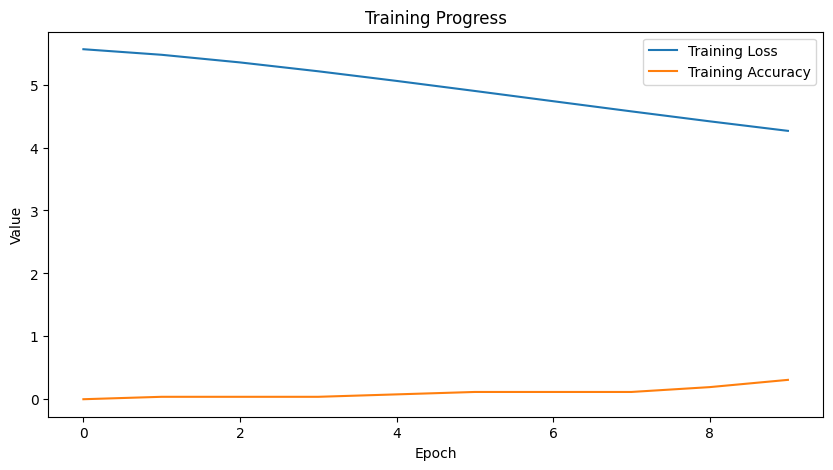

In [223]:
train_losses = []
train_accuracies = []
max_epochs = 10
for epoch in tqdm(range(max_epochs), desc="Training Classification; Epoch"):
    classifier.train()
    optimizer.zero_grad()
    output = classifier(features)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    
    # 損失と精度を記録
    train_losses.append(loss.item())
    predictions = output.argmax(dim=1)
    train_accuracy = (predictions == labels).float().mean().item()
    train_accuracies.append(train_accuracy)
print(f"Epoch {epoch + 1}/{max_epochs}, Loss: {loss.item():.4f}, Accuracy: {train_accuracy * 100:.2f}%")

# 損失と精度のプロット
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(train_accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.title('Training Progress')
plt.show()

Training Classification; Epoch: 100%|██████████| 1000/1000 [00:06<00:00, 165.77it/s]


Epoch 1000/1000, Loss: 1.0841, Accuracy: 90.70%


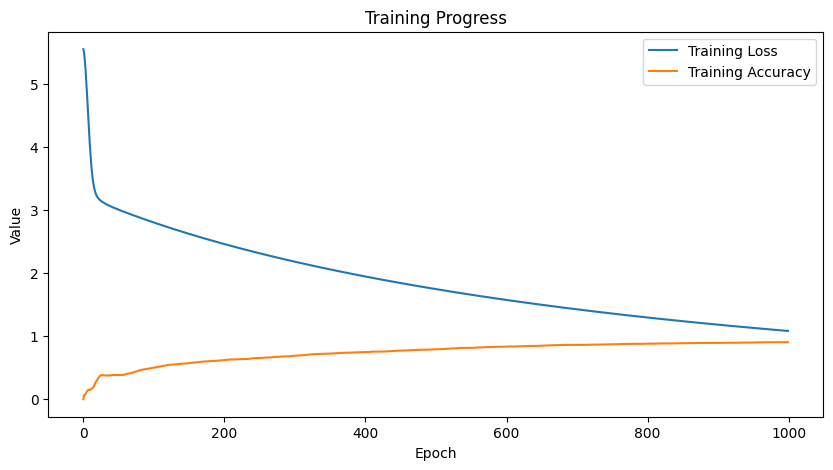

In [198]:
train_losses = []
train_accuracies = []
max_epochs = 1000
for epoch in tqdm(range(max_epochs), desc="Training Classification; Epoch"):
    classifier.train()
    optimizer.zero_grad()
    output = classifier(features)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    
    # 損失と精度を記録
    train_losses.append(loss.item())
    predictions = output.argmax(dim=1)
    train_accuracy = (predictions == labels).float().mean().item()
    train_accuracies.append(train_accuracy)
print(f"Epoch {epoch + 1}/{max_epochs}, Loss: {loss.item():.4f}, Accuracy: {train_accuracy * 100:.2f}%")

# 損失と精度のプロット
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(train_accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.title('Training Progress')
plt.show()

In [219]:
# テストデータで評価
# 特徴抽出
test_features = []
test_labels = []
with torch.no_grad():
    for images, target in dataloader_test:
        embedding = feature_extractor(images)
        test_features.append(embedding)
        test_labels.append(target)

test_features = torch.cat(test_features)
test_labels = torch.cat(test_labels)

# 分類器で予測
classifier.eval()
with torch.no_grad():
    predictions = classifier(test_features).argmax(dim=1)

# 精度計算
accuracy = (predictions == test_labels).float().mean()
print(f"Test Accuracy: {accuracy.item() * 100:.2f}%")

Test Accuracy: 79.77%


In [224]:
# テストデータで評価
# 特徴抽出
test_features = []
test_labels = []
with torch.no_grad():
    for images, target in dataloader_test:
        embedding = feature_extractor(images)
        test_features.append(embedding)
        test_labels.append(target)

test_features = torch.cat(test_features)
test_labels = torch.cat(test_labels)

# 分類器で予測
classifier.eval()
with torch.no_grad():
    predictions = classifier(test_features).argmax(dim=1)

# 精度計算
accuracy = (predictions == test_labels).float().mean()
print(f"Test Accuracy: {accuracy.item() * 100:.2f}%")

Test Accuracy: 4.92%


In [183]:
# テストデータクラスから訓練データクラスへのマッピング
test_to_train_map = {cls: dataset_train.classes.index(cls) for cls in dataset_test.classes}

# 特徴抽出
test_features = []
test_labels = []
with torch.no_grad():
    for images, target in dataloader_test:
        # ターゲット（ラベル）を訓練データクラスのインデックスにマッピング
        mapped_target = torch.tensor([test_to_train_map[dataset_test.classes[t]] for t in target], dtype=torch.long)

        embedding = feature_extractor(images)
        test_features.append(embedding)
        test_labels.append(mapped_target)

test_features = torch.cat(test_features)
test_labels = torch.cat(test_labels)

# 分類器で予測
classifier.eval()
with torch.no_grad():
    outputs = classifier(test_features)

    # テストデータに対応するクラスのみの出力を考慮
    test_class_indices = [dataset_train.classes.index(cls) for cls in dataset_test.classes]
    outputs_filtered = outputs[:, test_class_indices]

    predictions = outputs_filtered.argmax(dim=1)

# 精度計算
accuracy = (predictions == test_labels).float().mean()
print(f"Test Accuracy: {accuracy.item() * 100:.2f}%")

Test Accuracy: 23.28%


In [191]:
import torch

# top-k の値
k = 5

# テストデータで特徴抽出
test_features = []
test_labels = []
with torch.no_grad():
    for images, target in dataloader_test:
        embedding = feature_extractor(images)
        test_features.append(embedding)
        test_labels.append(target)

test_features = torch.cat(test_features)
test_labels = torch.cat(test_labels)

# 分類器で予測
classifier.eval()
with torch.no_grad():
    # クラスごとのスコアを取得
    logits = classifier(test_features)

    # Top-k のクラスを取得 (dim=1 がクラス軸)
    topk_predictions = torch.topk(logits, k=k, dim=1).indices

# 精度計算
# Top-1 Accuracy
top1_predictions = topk_predictions[:, 0]  # Top-1の予測（最大値のインデックス）
top1_accuracy = (top1_predictions == test_labels).float().mean()

# Top-k Accuracy
topk_accuracy = (topk_predictions == test_labels.view(-1, 1)).any(dim=1).float().mean()

# 結果を出力
print(f"Test Top-1 Accuracy: {top1_accuracy.item() * 100:.2f}%")
print(f"Test Top-{k} Accuracy: {topk_accuracy.item() * 100:.2f}%")

Test Top-1 Accuracy: 54.22%
Test Top-5 Accuracy: 75.55%


## 類似度

In [378]:
from tqdm import tqdm 

# 特徴ベクトルとラベルを準備
features = []
labels = []

with torch.no_grad():
    # tqdmでデータローダーをラップして進捗を表示
    for images, target in tqdm(dataloader_train, desc="Extracting features"):
        embedding = feature_extractor(images)  # 特徴を抽出
        features.append(embedding)
        labels.append(target)

features = torch.cat(features)
labels = torch.cat(labels)

assert len(features) == len(labels), "Features and labels length mismatch!"

Extracting features: 100%|██████████| 262/262 [00:02<00:00, 97.32it/s] 


In [383]:
labels[0][0]

tensor(0)

In [379]:
topk_labels[30:40][0][0][0]

tensor(196)

In [348]:
i = 0
while i < 5:
    for images, target in tqdm(dataloader_train, desc="Extracting features"):
        print(target)
        i+=1

Extracting features:  62%|██████▏   | 163/262 [00:00<00:00, 830.90it/s]

tensor([0])
tensor([1])
tensor([3])
tensor([4])
tensor([5])
tensor([6])
tensor([7])
tensor([8])
tensor([9])
tensor([10])
tensor([2])
tensor([11])
tensor([12])
tensor([13])
tensor([14])
tensor([15])
tensor([16])
tensor([17])
tensor([18])
tensor([19])
tensor([20])
tensor([27])
tensor([28])
tensor([29])
tensor([30])
tensor([31])
tensor([32])
tensor([33])
tensor([34])
tensor([21])
tensor([22])
tensor([23])
tensor([24])
tensor([25])
tensor([26])
tensor([35])
tensor([36])
tensor([40])
tensor([41])
tensor([42])
tensor([43])
tensor([44])
tensor([45])
tensor([46])
tensor([47])
tensor([37])
tensor([38])
tensor([39])
tensor([48])
tensor([49])
tensor([56])
tensor([57])
tensor([58])
tensor([59])
tensor([60])
tensor([61])
tensor([62])
tensor([63])
tensor([50])
tensor([51])
tensor([52])
tensor([53])
tensor([54])
tensor([55])
tensor([64])
tensor([65])
tensor([66])
tensor([67])
tensor([68])
tensor([69])
tensor([70])
tensor([71])
tensor([72])
tensor([73])
tensor([78])
tensor([79])
tensor([80])
tensor([8

Extracting features: 100%|██████████| 262/262 [00:00<00:00, 849.22it/s]

tensor([214])
tensor([223])
tensor([224])
tensor([230])
tensor([231])
tensor([232])
tensor([233])
tensor([234])
tensor([235])
tensor([236])
tensor([237])
tensor([225])
tensor([226])
tensor([227])
tensor([228])
tensor([229])
tensor([238])
tensor([239])
tensor([243])
tensor([244])
tensor([245])
tensor([246])
tensor([247])
tensor([248])
tensor([249])
tensor([250])
tensor([240])
tensor([241])
tensor([242])
tensor([251])
tensor([252])
tensor([254])
tensor([255])
tensor([256])
tensor([257])
tensor([258])
tensor([259])
tensor([260])
tensor([261])
tensor([253])
tensor([74])
tensor([75])
tensor([76])
tensor([77])
tensor([86])
tensor([109])
tensor([110])
tensor([111])
tensor([112])
tensor([113])
tensor([114])
tensor([115])
tensor([116])
tensor([117])
tensor([118])
tensor([87])
tensor([131])
tensor([132])
tensor([136])
tensor([137])
tensor([138])
tensor([139])
tensor([140])
tensor([141])
tensor([142])
tensor([143])
tensor([133])
tensor([134])
tensor([135])
tensor([85])
tensor([155])
tensor([156])

In [357]:
test_features = []
test_labels = []

# テストデータの特徴を抽出
with torch.no_grad():
    for images, targets in tqdm(dataloader_test, desc="Extracting test features"):
        embedding = feature_extractor(images)  # 特徴を抽出
        test_features.append(embedding)
        test_labels.append(targets)

# 特徴とラベルを結合
test_features = torch.cat(test_features)
test_labels = torch.cat(test_labels)

Extracting test features: 100%|██████████| 26/26 [00:02<00:00,  8.80it/s]


In [358]:
import torch.nn.functional as F

similarities = []

# テストデータをクラスごとのバッチで処理
for test_images, _ in tqdm(dataloader_test, desc="Calculating cosine similarities"):
    test_embedding = feature_extractor(test_images)  # テストバッチの特徴を抽出
    batch_similarities = F.cosine_similarity(
        test_embedding.unsqueeze(1),  # (test_batch_size, 1, D)
        features.unsqueeze(0),  # (1, train_samples, D)
        dim=2
    )  # 結果は (test_batch_size, train_samples)
    similarities.append(batch_similarities)

# 結果を結合
similarities = torch.cat(similarities, dim=0)  # (total_test_samples, train_samples)

Calculating cosine similarities: 100%|██████████| 26/26 [00:04<00:00,  6.33it/s]


In [359]:
import torch.nn.functional as F

features = F.normalize(features, p=2, dim=1)
test_features = F.normalize(test_features, p=2, dim=1)
# コサイン類似度を計算
similarities = F.cosine_similarity(test_features.unsqueeze(1), features.unsqueeze(0), dim=2)

# 上位k個を取得
k = 1
topk_indices = torch.topk(similarities, k=k, dim=1).indices

# 上位k個のラベルを取得
topk_labels = labels[topk_indices]

In [360]:
import torch

# 各サンプルごとに多数決で予測
predicted_labels = []
for sample_labels in topk_labels:
    # 各近傍のラベルの中で最頻値を取る
    predicted_label = torch.mode(sample_labels).values
    predicted_labels.append(predicted_label)

# 予測ラベルをTensorに変換
predicted_labels = torch.tensor(predicted_labels)

In [ ]:
predicted_labels

In [374]:
# 正解率を計算
accuracy = (predicted_labels[0] == test_labels[0]).float().mean().item()
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 50.00%


In [311]:
from collections import Counter

for i, sample_labels in enumerate(topk_labels[:10]):  # 最初の10サンプルで確認
    print(f"Test Sample {i}:")
    print("Top-k Labels:", sample_labels.tolist())
    print("Label Counts:", Counter(sample_labels.tolist()))

Test Sample 0:
Top-k Labels: [258]
Label Counts: Counter({258: 1})
Test Sample 1:
Top-k Labels: [258]
Label Counts: Counter({258: 1})
Test Sample 2:
Top-k Labels: [259]
Label Counts: Counter({259: 1})
Test Sample 3:
Top-k Labels: [111]
Label Counts: Counter({111: 1})
Test Sample 4:
Top-k Labels: [258]
Label Counts: Counter({258: 1})
Test Sample 5:
Top-k Labels: [92]
Label Counts: Counter({92: 1})
Test Sample 6:
Top-k Labels: [206]
Label Counts: Counter({206: 1})
Test Sample 7:
Top-k Labels: [253]
Label Counts: Counter({253: 1})
Test Sample 8:
Top-k Labels: [253]
Label Counts: Counter({253: 1})
Test Sample 9:
Top-k Labels: [251]
Label Counts: Counter({251: 1})


In [339]:
# 学習データとテストデータの次元を確認
print(f"Features shape (training data): {features.shape}")
print(f"Features shape (test data): {test_features.shape}")

# 次元が一致しているか確認
if features.shape[1] == test_features.shape[1]:
    print("The dimensions of the training and test feature vectors match.")
else:
    print("Dimension mismatch detected! Check the feature extraction process.")

Features shape (training data): torch.Size([262, 4096])
Features shape (test data): torch.Size([1280, 4096])
The dimensions of the training and test feature vectors match.


## 特徴空間マッピング

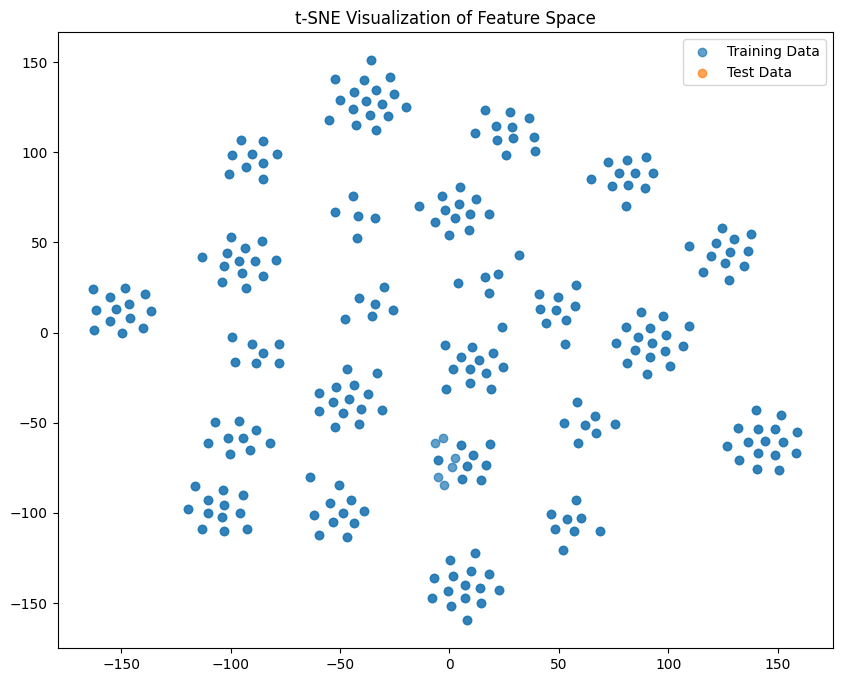

1048

In [325]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 結合して次元削減
all_features = torch.cat([features, test_features]).cpu().numpy()
tsne = TSNE(n_components=2, random_state=42)
reduced_features = tsne.fit_transform(all_features)

# 学習データとテストデータを区別してプロット
plt.figure(figsize=(10, 8))
plt.scatter(reduced_features[:524, 0], reduced_features[:524, 1], label="Training Data", alpha=0.7)
plt.scatter(reduced_features[524:, 0], reduced_features[524:, 1], label="Test Data", alpha=0.7)
#plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=labels.cpu().numpy(), cmap='tab10', alpha=0.7)
plt.legend()
plt.title("t-SNE Visualization of Feature Space")
plt.show()
reduced_features.size

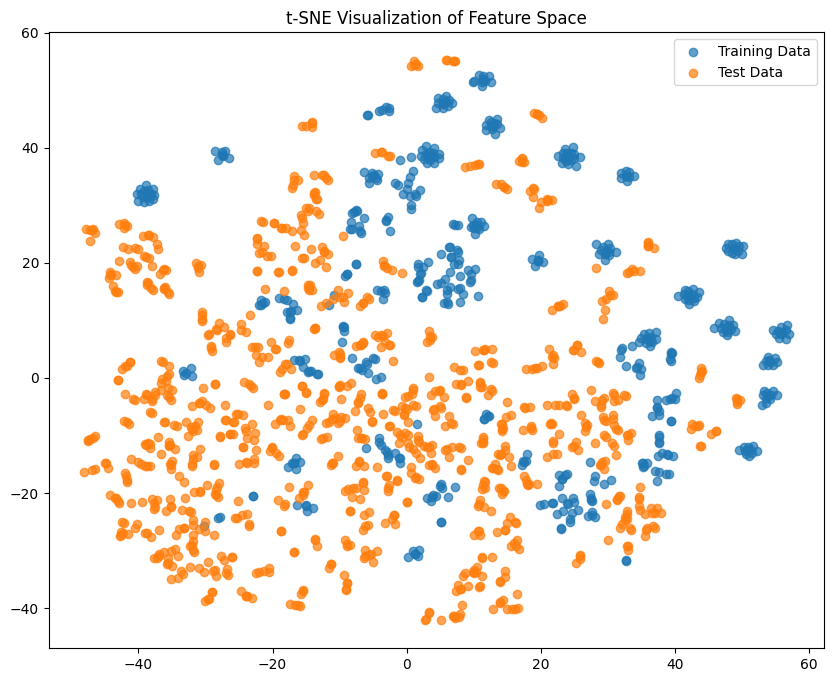

3084

In [333]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 結合して次元削減
all_features = torch.cat([features, test_features]).cpu().numpy()
tsne = TSNE(n_components=2, random_state=42)
reduced_features = tsne.fit_transform(all_features)

# 学習データとテストデータを区別してプロット
plt.figure(figsize=(10, 8))
plt.scatter(reduced_features[:524, 0], reduced_features[:524, 1], label="Training Data", alpha=0.7)
plt.scatter(reduced_features[524:, 0], reduced_features[524:, 1], label="Test Data", alpha=0.7)
#plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=labels.cpu().numpy(), cmap='tab10', alpha=0.7)
plt.legend()
plt.title("t-SNE Visualization of Feature Space")
plt.show()
reduced_features.size

In [205]:
import torch
from torch.utils.data import DataLoader

# 特徴ベクトルを保存するリスト
features = []
labels = []

with torch.no_grad():
    for images, targets in dataloader_test:
        # 特徴ベクトルを抽出
        embeddings = feature_extractor(images).flatten(start_dim=1)
        features.append(embeddings)
        labels.append(targets)

# 特徴とラベルを結合
features = torch.cat(features)  # [N, D] (N: サンプル数, D: 特徴次元)
labels = torch.cat(labels)  # [N]

In [186]:
import torch.nn.functional as F

# 特徴ベクトルを正規化
features = F.normalize(features, dim=1)

# コサイン類似度行列の計算
cosine_similarity_matrix = torch.mm(features, features.T)  # [N, N]

# 例: クラスごとの平均類似度を計算
unique_labels = labels.unique()
class_similarities = {}
for label in unique_labels:
    class_indices = (labels == label).nonzero(as_tuple=True)[0]
    class_features = features[class_indices]
    class_similarity = torch.mm(class_features, class_features.T).mean().item()
    class_similarities[label.item()] = class_similarity

print("Class-wise Average Cosine Similarities:")
for label, sim in class_similarities.items():
    print(f"Class {label}: {sim:.4f}")

Class-wise Average Cosine Similarities:
Class 0: 0.9509
Class 1: 0.9478
Class 2: 0.9481
Class 3: 0.9480
Class 4: 0.9568
Class 5: 0.9402
Class 6: 0.9474
Class 7: 0.9531
Class 8: 0.9440
Class 9: 0.9490
Class 10: 0.9519
Class 11: 0.9451
Class 12: 0.9483
Class 13: 0.9409
Class 14: 0.9357
Class 15: 0.9563
Class 16: 0.9440
Class 17: 0.9458
Class 18: 0.9498
Class 19: 0.9445
Class 20: 0.9413
Class 21: 0.9452
Class 22: 0.9456
Class 23: 0.9487
Class 24: 0.9442
Class 25: 0.9435


In [201]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# t-SNEによる次元削減
tsne = TSNE(n_components=2, random_state=0)
features_2d = tsne.fit_transform(features.cpu().numpy())

# 可視化
plt.figure(figsize=(8, 6))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels.cpu().numpy(), cmap='tab10', alpha=0.7)
plt.colorbar(scatter, label="Class Labels")
plt.title("t-SNE Visualization of tegaki data")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

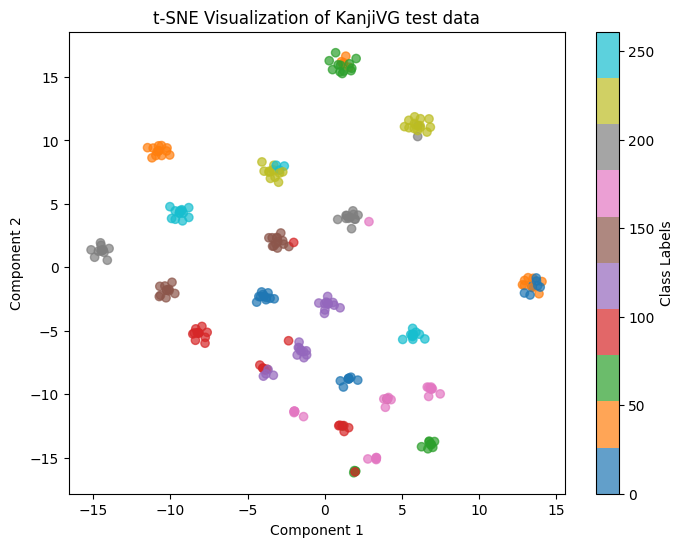

In [206]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# t-SNEによる次元削減
tsne = TSNE(n_components=2, random_state=0)
features_2d = tsne.fit_transform(features.cpu().numpy())

# 可視化
plt.figure(figsize=(8, 6))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels.cpu().numpy(), cmap='tab10', alpha=0.7)
plt.colorbar(scatter, label="Class Labels")
plt.title("t-SNE Visualization of KanjiVG test data")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

In [ ]:
transform_test_no_processing = transforms.Compose([
    transforms.Resize((64, 63), antialias=True),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

# 前処理なしで画像を表示
for i in range(5):
    img, label = dataset_test[i]
    img_no_processing = transform_test_no_processing(Image.open(dataset_test.image_paths[i]).convert('RGB'))
    plt.imshow(img_no_processing.squeeze(), cmap='gray')
    plt.title(f"Label: {label}")
    plt.show()


In [ ]:
import torch.nn.functional as F
normalized_features = F.normalize(features, dim=1)
print(normalized_features[:10])  # 正規化後の特徴ベクトルを確認

In [ ]:
image_path = '/home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/test/0x4fee/0x4fee-1.png'
image_path = '/home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/test/0x9aa8/0x9aa8-0.png'
image_path = '/home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/train/0x4e08/0x4e08-3.png'
#image_path = '/home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/test/0x4fee/0x4fee-0.png'
try:
    image = Image.open(image_path)#.convert('RGB')
except Exception as e:
    print(f"Error loading image at {image_path}: {e}")
image

In [ ]:
from PIL import Image

image_paths = [
    '/home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/test/0x4fee/0x4fee-1.png',
    '/home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/test/0x9aa8/0x9aa8-0.png',
    '/home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/train/0x4e08/0x4e08-3.png',
    '/home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/test/0x4fee/0x4fee-0.png',
]

for image_path in image_paths:
    try:
        # 画像を開いてRGBに変換
        image = Image.open(image_path).convert('RGB')
        print(f"Image at {image_path} converted to mode: {image.mode}")  # モードを出力
    except Exception as e:
        print(f"Error loading image at {image_path}: {e}")

In [ ]:
alpha_channel = image.split()[3]
print(f"Alpha channel unique values: {set(alpha_channel.getdata())}")

In [ ]:
import numpy as np
image_array = np.array(image)
print(f"Image array shape: {image_array.shape}")
print(f"Image array unique values: {np.unique(image_array)}")

In [21]:
import os
import shutil
import random

def move_subdirectories(src_dir, dest_dir, fraction=0.2):
    """
    src_dir のサブディレクトリのうち、指定された割合 (fraction) を dest_dir に移動する。

    Args:
        src_dir (str): 元のディレクトリパス。
        dest_dir (str): 新しいディレクトリパス。
        fraction (float): 移動する割合（例: 0.2 で全体の 20%）。
    """
    # src_dir 下のすべてのサブディレクトリを取得
    subdirs = [os.path.join(src_dir, d) for d in os.listdir(src_dir) if os.path.isdir(os.path.join(src_dir, d))]

    # 移動するサブディレクトリをランダムに選択
    num_to_move = max(1, int(len(subdirs) * fraction))  # 最低でも1つは移動
    selected_subdirs = random.sample(subdirs, num_to_move)

    # dest_dir が存在しない場合は作成
    os.makedirs(dest_dir, exist_ok=True)

    # 選択されたサブディレクトリを移動
    for subdir in selected_subdirs:
        dest_path = os.path.join(dest_dir, os.path.basename(subdir))
        shutil.copytree(subdir, dest_path)
        print(f"Moved: {subdir} -> {dest_path}")

    print(f"Total moved: {len(selected_subdirs)} subdirectories.")

# 実行例
src_directory = '/home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/train1'
dest_directory = '/data2/abababam1/HandwrittenTextAlign/simclr/data/train1_subset15'

move_subdirectories(src_directory, dest_directory, fraction=0.2)

Moved: /home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/train1/0x54c8 -> /data2/abababam1/HandwrittenTextAlign/simclr/data/train1_subset15/0x54c8
Moved: /home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/train1/0x6434 -> /data2/abababam1/HandwrittenTextAlign/simclr/data/train1_subset15/0x6434
Moved: /home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/train1/0x7281 -> /data2/abababam1/HandwrittenTextAlign/simclr/data/train1_subset15/0x7281
Moved: /home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/train1/0x8fa3 -> /data2/abababam1/HandwrittenTextAlign/simclr/data/train1_subset15/0x8fa3
Moved: /home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/train1/0x7027 -> /data2/abababam1/HandwrittenTextAlign/simclr/data/train1_subset15/0x7027
Moved: /home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/train1/0x6089 -> /data2/abababam1/HandwrittenTextAlign/simclr/data/train1_subset15/0x6089
Moved: /home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/train1/0x5283 -> /data2/abababam1

In [51]:
import os
import shutil

# ベースディレクトリ
input_dir = "/home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/train"
output_dir = "/home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/train1"

for base_dir in glob.glob(f'{input_dir}/*'):
    subdir_name = os.path.basename(base_dir)
    # subdir内のPNGファイルをリストアップ
    png_files = [f for f in os.listdir(base_dir) if f.endswith('.png')]

    # PNGファイルを新しいディレクトリに移動・リネーム
    for file_name in png_files:
        old_file_path = os.path.join(base_dir, file_name)

        # 新しいディレクトリ名とパス
        idx = re.search(r'-(\d+)(?=\..*$)', file_name).group(1)
        new_subdir_name = f"{subdir_name}-{idx}"
        new_subdir_path = os.path.join(output_dir, subdir_name, new_subdir_name)
        os.makedirs(new_subdir_path, exist_ok=True)  # 新しいディレクトリを作成

        # 新しいファイル名とパス
        new_file_name = f"{new_subdir_name}.png"
        new_file_path = os.path.join(new_subdir_path, new_file_name)

        # ファイルを移動・リネーム
        shutil.move(old_file_path, new_file_path)
        print(f"Moved: {old_file_path} -> {new_file_path}")

    print("構造の変更が完了しました。")

Moved: /home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/train/0x4e01/0x4e01-0.png -> /home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/train1/0x4e01/0x4e01-0/0x4e01-0.png
Moved: /home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/train/0x4e01/0x4e01-1.png -> /home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/train1/0x4e01/0x4e01-1/0x4e01-1.png
Moved: /home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/train/0x4e01/0x4e01-2.png -> /home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/train1/0x4e01/0x4e01-2/0x4e01-2.png
構造の変更が完了しました。
Moved: /home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/train/0x4e03/0x4e03-0.png -> /home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/train1/0x4e03/0x4e03-0/0x4e03-0.png
Moved: /home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/train/0x4e03/0x4e03-1.png -> /home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/train1/0x4e03/0x4e03-1/0x4e03-1.png
Moved: /home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/train/0x4e03/0x4e03-2.png

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Moved: /home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/train/0x81df/0x81df-15.png -> /home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/train1/0x81df/0x81df-15/0x81df-15.png
Moved: /home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/train/0x81df/0x81df-16.png -> /home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/train1/0x81df/0x81df-16/0x81df-16.png
Moved: /home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/train/0x81df/0x81df-17.png -> /home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/train1/0x81df/0x81df-17/0x81df-17.png
Moved: /home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/train/0x81df/0x81df-18.png -> /home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/train1/0x81df/0x81df-18/0x81df-18.png
Moved: /home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/train/0x81df/0x81df-19.png -> /home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/train1/0x81df/0x81df-19/0x81df-19.png
Moved: /home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/train/0x81df/0x81df-20.p

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

